In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
def load_window_samples(csv_paths, max_seq_len=50, drop_cols=None):
    if drop_cols is None:
        drop_cols = [
            'Ventana_Inicio', 'Flow ID', 'Src IP', 'Src Port',
            'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Label'
        ]
    all_dfs = []
    for label_name, paths in csv_paths.items():
        if isinstance(paths, str):
            paths = [paths]
        for path in paths:
            print(f"[INFO] Loading {path} as '{label_name}'")
            df_temp = pd.read_csv(path)
            df_temp['Label'] = df_temp.get('Label', label_name)
            all_dfs.append(df_temp)

    df = pd.concat(all_dfs, ignore_index=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    unique_labels = df['Label'].unique().tolist()
    label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}

    # Características numéricas
    feat_df = df.drop(columns=drop_cols, errors='ignore')
    numeric_cols = feat_df.select_dtypes(include=[np.number]).columns.tolist()

    # Agrupar por ventanas
    samples = []
    for vid, subdf in df.groupby('Ventana_Inicio'):
        if 'Timestamp' in subdf.columns:
            subdf = subdf.sort_values('Timestamp')
        lbl_idx = label_to_idx[subdf['Label'].iloc[0]]
        feats = subdf[numeric_cols].to_numpy(dtype=np.float32)
        # Truncar o rellenar
        if feats.shape[0] > max_seq_len:
            feats = feats[:max_seq_len]
        elif feats.shape[0] < max_seq_len:
            pad_len = max_seq_len - feats.shape[0]
            pad = np.zeros((pad_len, feats.shape[1]), dtype=np.float32)
            feats = np.vstack([feats, pad])
        samples.append((feats, lbl_idx))

    print(f"[INFO] Loaded {len(samples)} windows")
    return samples, len(numeric_cols), label_to_idx

In [3]:
class WindowDataset(Dataset):
    def __init__(self, samples, scaler):
        self.samples = samples
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        arr, lbl = self.samples[idx]
        flat = arr.reshape(-1, arr.shape[1])
        scaled = self.scaler.transform(flat).reshape(arr.shape)
        return torch.from_numpy(scaled), torch.tensor(lbl, dtype=torch.long)

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0, 'd_model debe ser divisible por num_heads.'
        self.d_k = self.d_v = d_model // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        B = Q.size(0)
        Q = self.W_q(Q).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_k(K).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_v(V).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1,2).contiguous().view(B, -1, self.num_heads * self.d_k)
        return self.W_o(out), attn

class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.do1 = nn.Dropout(dropout)
        self.do2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.do1(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.do2(ffn_out))
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderSubLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super().__init__()
        pe = torch.zeros(max_seq_len, d_model)
        pos = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderClassifierWithCLS(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_dim, num_classes, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = PositionalEmbedding(d_model, max_seq_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        B = x.size(0)
        x = self.input_proj(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_embed(x)
        x = self.encoder(x, mask)
        return self.classifier(x[:, 0, :])

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.wait = 0
        self.stop = False

    def step(self, metric):
        if self.best is None or metric < self.best - self.min_delta:
            self.best = metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True


def train_one_epoch(model, dl, opt, crit, clip_grad=None):
    model.train()
    total_loss = 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = crit(logits, y)
        loss.backward()
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        opt.step()
        total_loss += loss.item()
    return total_loss / len(dl)


def evaluate(model, dl, crit):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = crit(logits, y)
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return total_loss / len(dl), correct / total

In [6]:
# --- Celda 6: Pipeline principal y entrenamiento/evaluación de test ---
csv_paths = {
    "BENIGN": ["./Benign_0.csv", "./Benign_1.csv", "./Benign_2.csv", "./Benign_3.csv"],
    "DDoS-ICMP": "./DDoS-ICMP_0.csv",
    "DoS-TCP": [
        "./DoS-TCP-0_00000_Flow_ventanas.csv",
        "./DoS-TCP-0_00001_Flow_ventanas.csv",
        "./DoS-TCP-0_00004_Flow_ventanas.csv",
        "./DoS-TCP-1_00000_Flow_ventanas.csv",
        "./DoS-TCP-1_00002_Flow_ventanas.csv",
        "./DoS-TCP-1_00004_Flow_ventanas.csv",
        "./DoS-TCP-2_00000_Flow_ventanas.csv",
        "./DoS-TCP-2_00001_Flow_ventanas.csv",
        "./DoS-TCP-2_00002_Flow_ventanas.csv",
        "./DoS-TCP-2_00004_Flow_ventanas.csv"
    ],
    "DDoS-TCP": [
        "./DDoS-TCP-0_Flow_ventanas.csv",
        "./DDoS-TCP-1_Flow_ventanas.csv",
        "./DDoS-TCP-2_Flow_ventanas.csv",
        "./DDoS-TCP-3_Flow_ventanas.csv"
    ],
    "OSScan": "./Recon-OSScan.pcap_Flow_ventanas.csv",
    "PortScan": "./Recon-PortScan.pcap_Flow_ventanas.csv"
}

# 6.1) Cargar muestras y mapping
samples, n_features, label_to_idx = load_window_samples(csv_paths, max_seq_len=127)
print("Label to index mapping:", label_to_idx)

# 6.2) División estratificada y particiones
y = [lbl for _, lbl in samples]
idxs = np.arange(len(samples))
trv_idx, test_idx = train_test_split(idxs, test_size=0.2, stratify=y, random_state=42)
tr_idx, val_idx = train_test_split(trv_idx, test_size=0.2, stratify=[y[i] for i in trv_idx], random_state=42)

train_samps = [samples[i] for i in tr_idx]
val_samps   = [samples[i] for i in val_idx]
test_samps  = [samples[i] for i in test_idx]

# 6.3) Ajuste del scaler en train
train_flat = np.vstack([arr.reshape(-1, n_features) for arr, _ in train_samps])
scaler = StandardScaler().fit(train_flat)

# 6.4) Creación de datasets y loaders
train_ds = WindowDataset(train_samps, scaler)
val_ds   = WindowDataset(val_samps, scaler)
test_ds  = WindowDataset(test_samps, scaler)
bs = 32
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=bs)
test_loader  = DataLoader(test_ds,  batch_size=bs)

# 6.5) Instanciación del modelo, criterio, optimizador y EarlyStopping
d_model, heads, d_ff, n_layers = 64, 4, 128, 2
model = TransformerEncoderClassifierWithCLS(
    d_model=d_model, num_heads=heads, d_ff=d_ff,
    num_layers=n_layers, input_dim=n_features,
    num_classes=len(label_to_idx), max_seq_len=128
).to(device)

crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience=5)

# 6.6) Bucle de entrenamiento con EarlyStopping
epochs = 50
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader, opt, crit, clip_grad=1.0)
    val_loss, val_acc = evaluate(model, val_loader, crit)
    print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    early_stopping.step(val_loss)
    if early_stopping.stop:
        print(f"Early stopping at epoch {epoch}")
        break

# 6.7) Evaluación final en test
test_loss, test_acc = evaluate(model, test_loader, crit)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

[INFO] Loading ./Benign_0.csv as 'BENIGN'
[INFO] Loading ./Benign_1.csv as 'BENIGN'
[INFO] Loading ./Benign_2.csv as 'BENIGN'
[INFO] Loading ./Benign_3.csv as 'BENIGN'
[INFO] Loading ./DDoS-ICMP_0.csv as 'DDoS-ICMP'
[INFO] Loading ./DoS-TCP-0_00000_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-0_00001_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-0_00004_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-1_00000_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-1_00002_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-1_00004_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-2_00000_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-2_00001_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-2_00002_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DoS-TCP-2_00004_Flow_ventanas.csv as 'DoS-TCP'
[INFO] Loading ./DDoS-TCP-0_Flow_ventanas.csv as 'DDoS-TCP'
[INFO] Loading ./DDoS-TCP-1_Flow_ventanas.csv as 'DDoS-TCP'
[INFO] Loading ./DDoS-TC

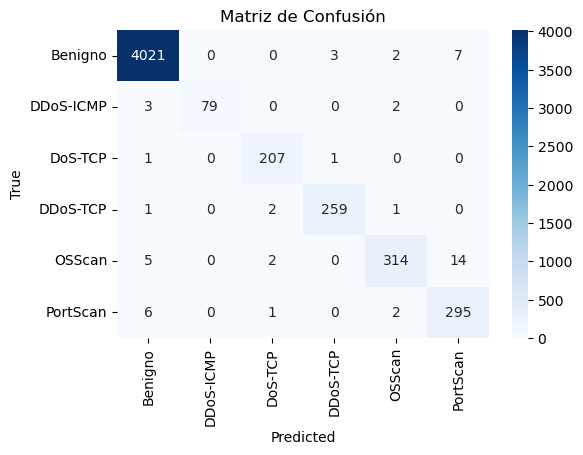

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true_list = []
y_pred_list = []
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        preds = torch.argmax(logits, dim=1)
        y_true_list.extend(batch_y.cpu().numpy())
        y_pred_list.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true_list, y_pred_list)
class_names = list(label_to_idx.keys())

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

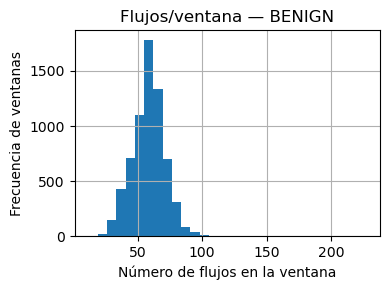

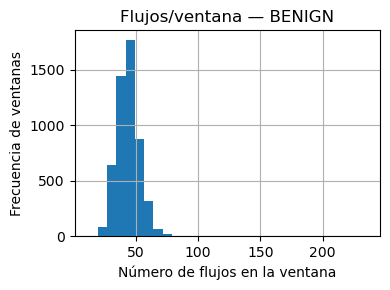

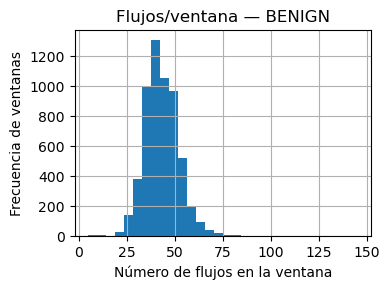

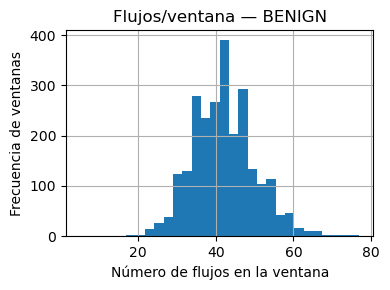

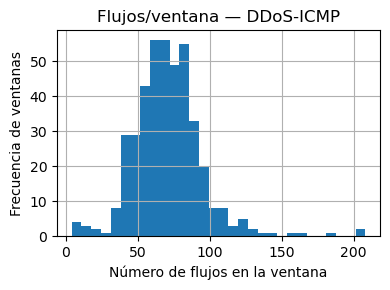

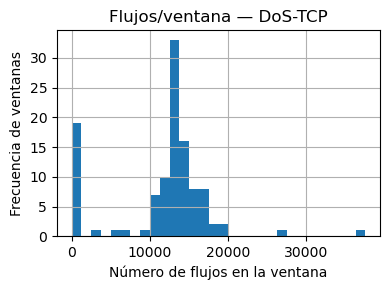

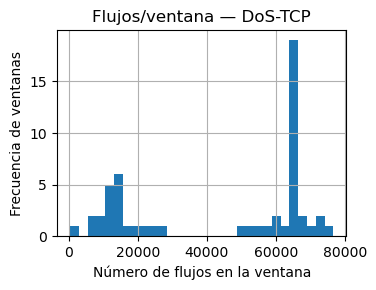

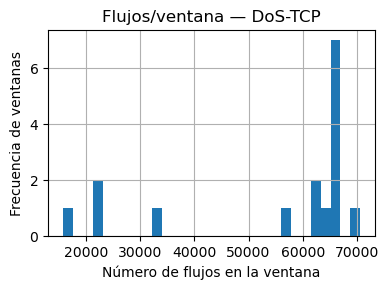

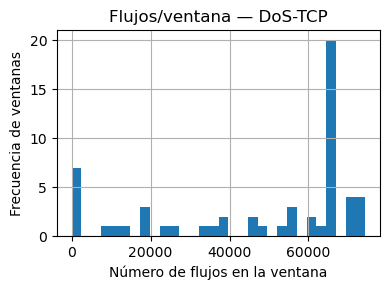

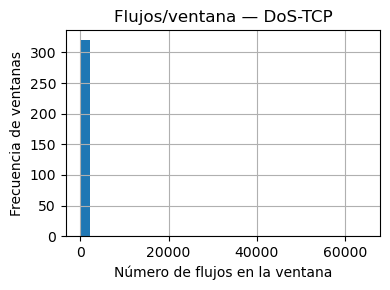

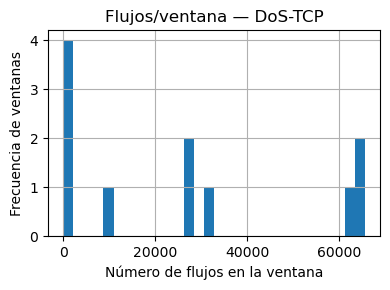

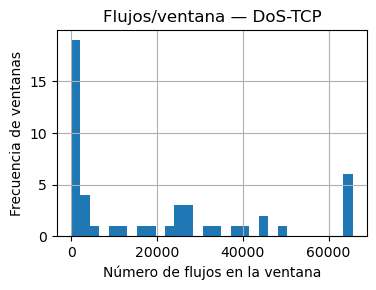

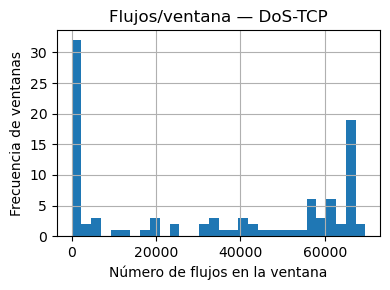

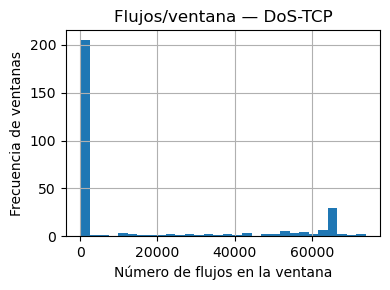

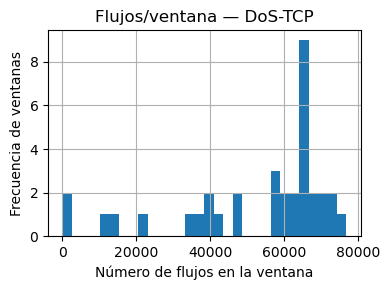

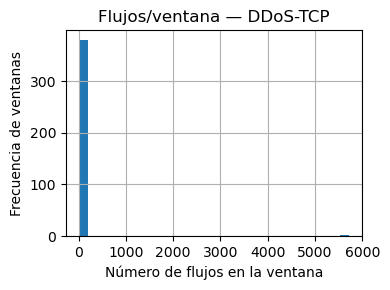

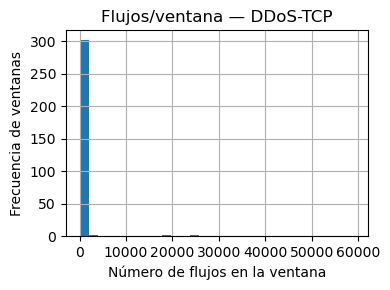

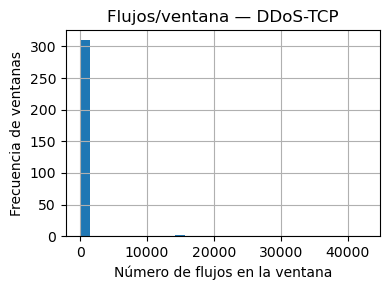

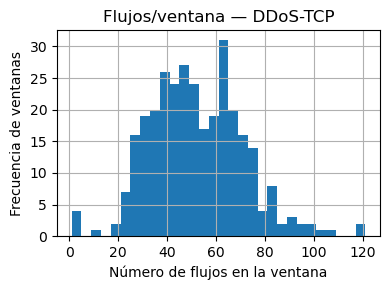

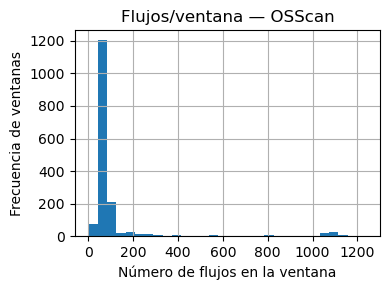

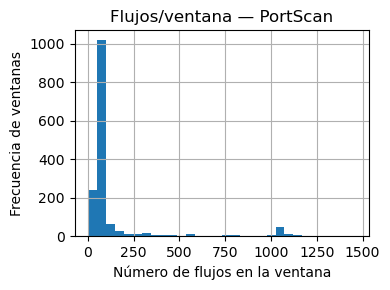

                                       file      label  n_windows  min_flows  \
0                            ./Benign_0.csv     BENIGN       6667         12   
1                            ./Benign_1.csv     BENIGN       5220         12   
2                            ./Benign_2.csv     BENIGN       5785          5   
3                            ./Benign_3.csv     BENIGN       2493          5   
4                         ./DDoS-ICMP_0.csv  DDoS-ICMP        421          4   
5       ./DoS-TCP-0_00000_Flow_ventanas.csv    DoS-TCP        111          2   
6       ./DoS-TCP-0_00001_Flow_ventanas.csv    DoS-TCP         53        352   
7       ./DoS-TCP-0_00004_Flow_ventanas.csv    DoS-TCP         16      15751   
8       ./DoS-TCP-1_00000_Flow_ventanas.csv    DoS-TCP         57          3   
9       ./DoS-TCP-1_00002_Flow_ventanas.csv    DoS-TCP        330          2   
10      ./DoS-TCP-1_00004_Flow_ventanas.csv    DoS-TCP         11         37   
11      ./DoS-TCP-2_00000_Flow_ventanas.

In [15]:
# --- Celda 9: Estudio del número de flujos por ventana de cada CSV ---
import pandas as pd
import matplotlib.pyplot as plt

# Diccionario con las rutas (igual al usado en la Celda 6)
csv_paths = {
    "BENIGN": ["./Benign_0.csv", "./Benign_1.csv", "./Benign_2.csv", "./Benign_3.csv"],
    "DDoS-ICMP": "./DDoS-ICMP_0.csv",
    "DoS-TCP": [
        "./DoS-TCP-0_00000_Flow_ventanas.csv",
        "./DoS-TCP-0_00001_Flow_ventanas.csv",
        "./DoS-TCP-0_00004_Flow_ventanas.csv",
        "./DoS-TCP-1_00000_Flow_ventanas.csv",
        "./DoS-TCP-1_00002_Flow_ventanas.csv",
        "./DoS-TCP-1_00004_Flow_ventanas.csv",
        "./DoS-TCP-2_00000_Flow_ventanas.csv",
        "./DoS-TCP-2_00001_Flow_ventanas.csv",
        "./DoS-TCP-2_00002_Flow_ventanas.csv",
        "./DoS-TCP-2_00004_Flow_ventanas.csv"
    ],
    "DDoS-TCP": [
        "./DDoS-TCP-0_Flow_ventanas.csv",
        "./DDoS-TCP-1_Flow_ventanas.csv",
        "./DDoS-TCP-2_Flow_ventanas.csv",
        "./DDoS-TCP-3_Flow_ventanas.csv"
    ],
    "OSScan": "./Recon-OSScan.pcap_Flow_ventanas.csv",
    "PortScan": "./Recon-PortScan.pcap_Flow_ventanas.csv"
}

# Recopilar estadísticas
summary = []
for label, paths in csv_paths.items():
    if isinstance(paths, str):
        paths = [paths]
    for path in paths:
        df = pd.read_csv(path)
        counts = df.groupby('Ventana_Inicio').size()
        summary.append({
            'file': path,
            'label': label,
            'n_windows': counts.size,
            'min_flows': counts.min(),
            'max_flows': counts.max(),
            'mean_flows': counts.mean(),
            'median_flows': counts.median()
        })
        # Histograma opcional por archivo
        plt.figure(figsize=(4,3))
        counts.hist(bins=30)
        plt.title(f'Flujos/ventana — {label}')
        plt.xlabel('Número de flujos en la ventana')
        plt.ylabel('Frecuencia de ventanas')
        plt.tight_layout()
        plt.show()

# Mostrar tabla resumen
import seaborn as sns
import pandas as pd
summary_df = pd.DataFrame(summary)
print(summary_df)

In [17]:
summary_df

,file,label,n_windows,min_flows,max_flows,mean_flows,median_flows
0,./Benign_0.csv,BENIGN,6667,12,227,58.427029,59.0
1,./Benign_1.csv,BENIGN,5220,12,235,43.918966,43.0
2,./Benign_2.csv,BENIGN,5785,5,145,43.072083,43.0
3,./Benign_3.csv,BENIGN,2493,5,77,42.010028,42.0
4,./DDoS-ICMP_0.csv,DDoS-ICMP,421,4,208,70.862233,69.0
5,./DoS-TCP-0_00000_Flow_ventanas.csv,DoS-TCP,111,2,37587,11603.963964,13071.0
6,./DoS-TCP-0_00001_Flow_ventanas.csv,DoS-TCP,53,352,76705,44558.377358,61162.0
7,./DoS-TCP-0_00004_Flow_ventanas.csv,DoS-TCP,16,15751,70619,54415.187500,64736.5
8,./DoS-TCP-1_00000_Flow_ventanas.csv,DoS-TCP,57,3,74421,47755.035088,63284.0
9,./DoS-TCP-1_00002_Flow_ventanas.csv,DoS-TCP,330,2,64624,1295.903030,62.0
